**Causal Inference**
**Ethan Pirso - 260863065**

**Context**
Understanding what will be the Burn Rate for the employee working in an organization based on the current pandemic situation where work from home is a boon and a bane. How are employees' Burn Rate affected based on various conditions provided?

**Content**
Globally, World Mental Health Day is celebrated on October 10 each year. The objective of this day is to raise awareness about mental health issues around the world and mobilize efforts in support of mental health. According to an anonymous survey, about 450 million people live with mental disorders that can be one of the primary causes of poor health and disability worldwide. These days when the world is suffering from a pandemic situation, it becomes really hard to maintain mental fitness.

Employee ID: The unique ID allocated for each employee (example: fffe390032003000)
Date of Joining: The date-time when the employee has joined the organization (example: 2008-12-30)
Gender: The gender of the employee (Male/Female)
Company Type: The type of company where the employee is working (Service/Product)
WFH Setup Available: Is the work from home facility available for the employee (Yes/No)
Designation: The designation of the employee of work in the organization.
In the range of [0.0, 5.0] bigger is higher designation.
Resource Allocation: The amount of resource allocated to the employee to work, ie. number of working hours.
In the range of [1.0, 10.0] (higher means more resource)
Mental Fatigue Score: The level of fatigue mentally the employee is facing.
In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.
Burn Rate: The value we need to predict for each employee telling the rate of Bur out while working.
In the range of [0.0, 1.0] where the higher the value is more is the burn out.

**Acknowledgements**
A special thanks to the HackerEarth Competition on the topic "HackerEarth Machine Learning Challenge: Are your employees burning out? which can be accessed here for this data collection.

**Inspiration**
Try to build some really amazing predictions keeping in mind that happy and healthy employees are indisputably more productive at work, and in turn, help the business flourish profoundly.

In [81]:
# Import necessary libraries
import pandas as pd
from datetime import datetime
from dowhy import CausalModel
import dowhy.datasets

In [82]:
# Load the data
df = pd.read_csv('employee_burnout.csv')
print(df.shape)

(22750, 9)


In [83]:
# Drop rows with missing values in the target variable
df = df.dropna(subset=['Burn Rate'])
print(df.shape)

(21626, 9)


In [84]:
# Drop Employee ID column
df.drop(['Employee ID'], axis=1, inplace=True)

# Impute missing values
# Assuming 'Resource Allocation' and 'Mental Fatigue Score' are the features with missing values
df['Resource Allocation'] = df['Resource Allocation'].fillna(df['Resource Allocation'].mean())
df['Mental Fatigue Score'] = df['Mental Fatigue Score'].fillna(df['Mental Fatigue Score'].mean())

# Convert categorical variables to binary encoding
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Company Type'] = df['Company Type'].map({'Service': 0, 'Product': 1})
df['WFH Setup Available'] = df['WFH Setup Available'].map({'No': 0, 'Yes': 1})

# Convert 'Date of Joining' to datetime
df['Date of Joining'] = pd.to_datetime(df['Date of Joining'])

# Calculate the number of days to present
df['Days to Present'] = (datetime.now() - df['Date of Joining']).dt.days

# Standardize the 'Days to Present' column between 0 and 1
df['Days to Present'] = (df['Days to Present'] - df['Days to Present'].min()) / (df['Days to Present'].max() - df['Days to Present'].min())

# Drop Date of Joining column
df.drop(['Date of Joining'], axis=1, inplace=True)

df.head()


,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Days to Present
0,1,0,0,2.0,3.000000,3.8,0.16,0.252055
1,0,0,1,1.0,2.000000,5.0,0.36,0.084932
2,1,1,1,2.0,4.483831,5.8,0.49,0.810959
3,0,0,1,1.0,1.000000,2.6,0.20,0.158904
4,1,0,0,3.0,7.000000,6.9,0.52,0.438356


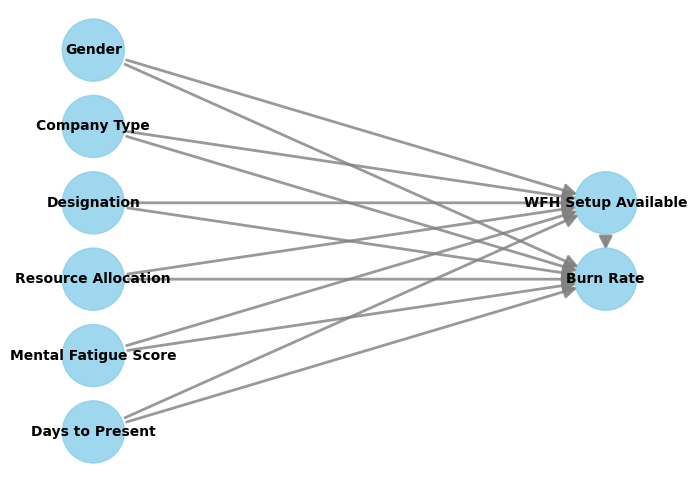

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                                   
──────────────────────(E[Burn Rate|Resource Allocation,Gender,Mental Fatigue S
d[WFH Setup Available]                                                        

                                               
core,Company Type,Days to Present,Designation])
                                               
Estimand assumption 1, Unconfoundedness: If U→{WFH Setup Available} and U→Burn Rate then P(Burn Rate|WFH Setup Available,Resource Allocation,Gender,Mental Fatigue Score,Company Type,Days to Present,Designation,U) = P(Burn Rate|WFH Setup Available,Resource Allocation,Gender,Mental Fatigue Score,Company Type,Days to Present,Designation)

## Realized estimand
b: Burn Rate~WFH Setup Available+Resource Allocation+Gender+Mental Fatigue Score+Company Type+Days to 

In [85]:
# Define treatment and outcome features
treatment = ['WFH Setup Available']
outcome = 'Burn Rate'

# Create a list of all column names to be considered as potential common causes
potential_common_causes = df.columns.tolist()

# Remove the treatment and outcome variables from the list of common causes
for treat in treatment:
    if treat in potential_common_causes:
        potential_common_causes.remove(treat)
if outcome in potential_common_causes:
    potential_common_causes.remove(outcome)

# Create CausalModel
causal_model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=potential_common_causes
)

# Visualize the model
causal_model.view_model()

# Identify the causal effect
identified_effect = causal_model.identify_effect()

# Estimate the causal effect
estimate = causal_model.estimate_effect(identified_effect,
                                        method_name="backdoor.linear_regression")

# Print the estimate
print(estimate)

# Refute the estimate
refute_results = causal_model.refute_estimate(identified_effect, estimate,
                                              method_name="random_common_cause")
print(refute_results)


### Conclusion

#### Hypothesis
The central hypothesis of this analysis was to determine if the availability of Work From Home (WFH) setups has a causal impact on the Burn Rate of employees during the current pandemic situation. The hypothesis posits that WFH setups, alongside other factors such as Resource Allocation, Gender, Mental Fatigue Score, Company Type, Days to Present, and Designation, could influence the mental health and productivity of employees, thereby affecting their Burn Rate.

#### Causal Analysis Results
The causal analysis, conducted using a DoWhy framework, yielded an estimated mean effect of -0.016998072993534563 on the Burn Rate due to the availability of WFH setups. This result indicates that having a WFH setup available is associated with a slight decrease in the Burn Rate among employees.

#### Interpretation of Outcome
The negative mean value of the estimated causal effect suggests that the availability of a WFH setup potentially leads to a minor reduction in the Burn Rate of employees. This reduction, though statistically significant, is relatively small in magnitude, indicating that while WFH setups may contribute to alleviating employee burnout to some extent, they are not the sole determining factor.

The additional analysis, "Refute: Add a random common cause," further supports the robustness of this causal estimate. The slight change in the effect size (from -0.016998072993534563 to -0.016999392974292992) after introducing a random common cause, along with a high p-value of 0.92, suggests that the observed causal relationship is stable and not significantly influenced by potential unobserved confounders.

#### Contextual Understanding
Given the context of the current pandemic and its impact on mental health, as highlighted by the World Mental Health Day, the slight decrease in Burn Rate due to WFH setups is an insightful finding. It implies that enabling employees to work from home could be one of several measures that help mitigate burnout. However, the study also underscores the complexity of mental health issues and employee burnout, indicating that multiple factors contribute to these challenges.

#### Conclusion
In summary, the hypothesis that the availability of WFH setups causally reduces the Burn Rate among employees is supported, albeit the effect size is small. This finding contributes to the broader discourse on employee well-being and productivity, emphasizing the importance of considering various strategies to support mental health and reduce burnout. Employers and policymakers should consider multifaceted approaches that address not only the physical work environment but also the psychological needs of employees, resource allocation fairness, and the significance of job roles and designations in mitigating the risk of burnout.